In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/bloodcell_dataset.zip'
extract_path = '/content/blood_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)

✅ Dataset extracted to: /content/blood_dataset


In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [ ]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
data_dir = '/content/blood_dataset/bloodcells_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    if fold in ['ig', 'neutrophil']:
        continue
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

df.head()

filepaths    labels
0  /content/blood_dataset/bloodcells_dataset/plat...  platelet
1  /content/blood_dataset/bloodcells_dataset/plat...  platelet
2  /content/blood_dataset/bloodcells_dataset/plat...  platelet
3  /content/blood_dataset/bloodcells_dataset/plat...  platelet
4  /content/blood_dataset/bloodcells_dataset/plat...  platelet

In [ ]:
df.shape

(10868, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  10868 non-null  object
 1   labels     10868 non-null  object
dtypes: object(2)
memory usage: 169.9+ KB


In [ ]:
labelscount = df['labels'].value_counts().reset_index()
labelscount

labels  count
0    eosinophil   3117
1      platelet   2348
2  erythroblast   1551
3      monocyte   1420
4      basophil   1218
5    lymphocyte   1214

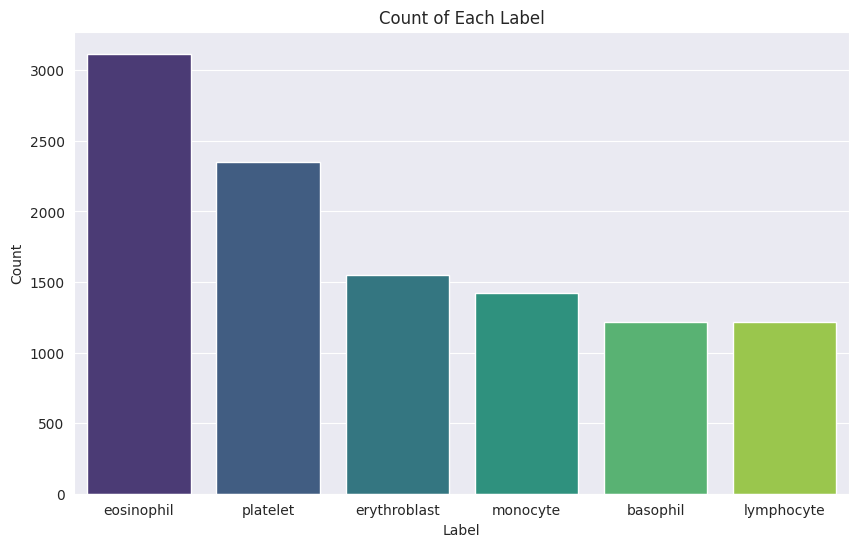

In [ ]:
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='labels', y='count', data=labelscount, palette='viridis')

# Add title and labels
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  test_size= 0.2, shuffle= True, random_state= 43)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 43)

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)


Found 8694 validated image filenames belonging to 6 classes.
Found 1087 validated image filenames belonging to 6 classes.
Found 1087 validated image filenames belonging to 6 classes.


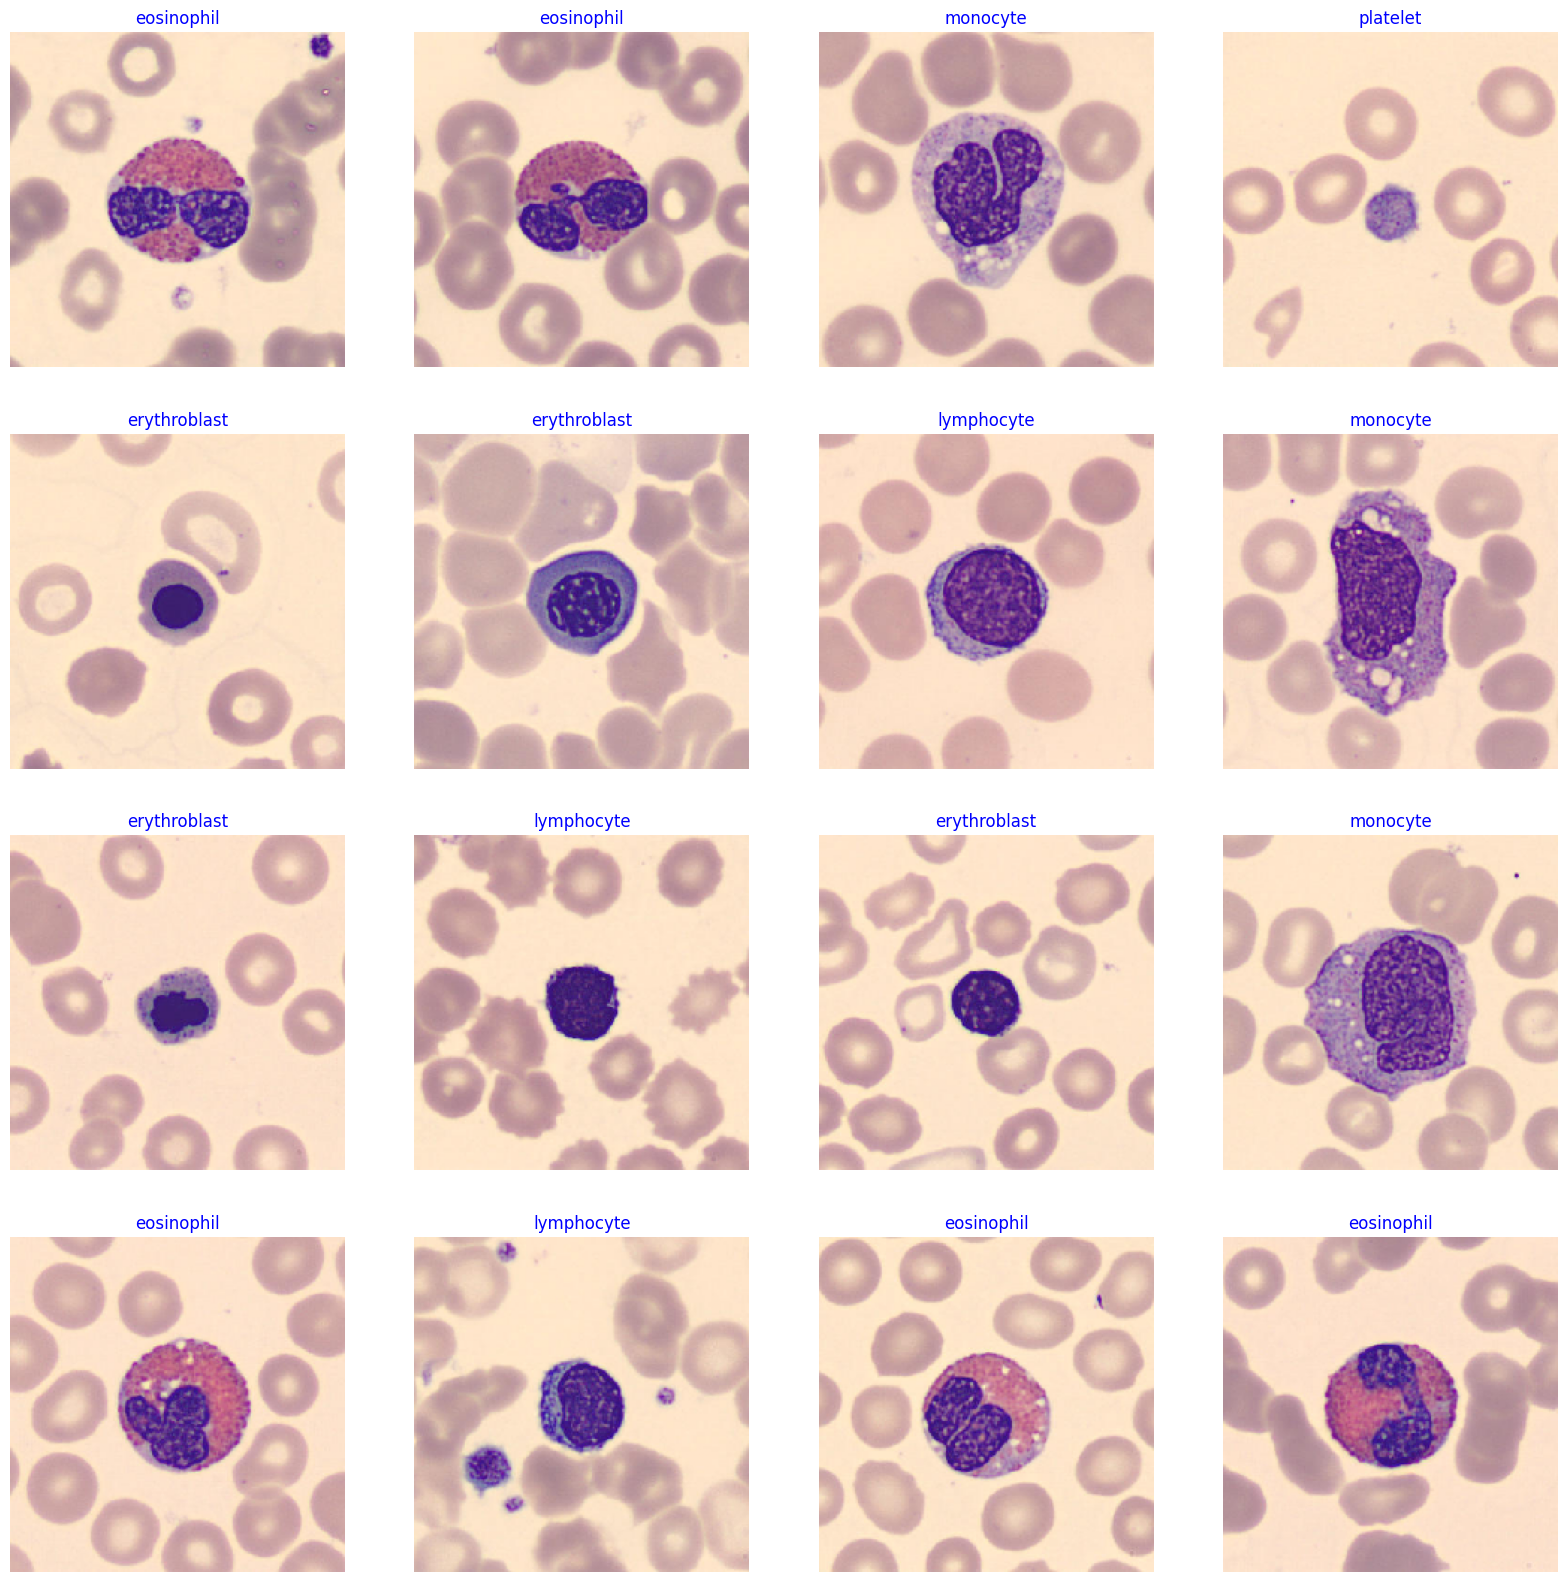

In [ ]:
# ٍShow Random Smaples from the Data
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()


In [ ]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained EfficientNetB3 model without the top layer
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False


# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling to match the target shape
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,184,693 (42.67 MB)

 Trainable params: 398,086 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
history1 = model.fit(train_gen, epochs=10, verbose=1, validation_data=valid_gen, shuffle=False)

# Save the entire model to a HDF5 file
model.save('bc_EfficientNetB3.h5')

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 96s 107ms/step - accuracy: 0.6272 - loss: 11.3046 - val_accuracy: 0.7728 - val_loss: 4.5440
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.7265 - loss: 3.9317 - val_accuracy: 0.9126 - val_loss: 2.1353
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.7771 - loss: 2.0561 - val_accuracy: 0.9246 - val_loss: 1.2314
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.8133 - loss: 1.3684 - val_accuracy: 0.9430 - val_loss: 0.9504
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.8149 - loss: 1.1783 - val_accuracy: 0.9586 - val_loss: 0.8237
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.8343 - loss: 1.0724 - val_accuracy: 0.9595 - val_loss: 0.7566
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.8211 - loss: 1.0287 - val_accuracy: 0.9660 - val_loss: 0.7063
Epoch 8/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - accuracy: 0.8398 - loss: 0.9721 

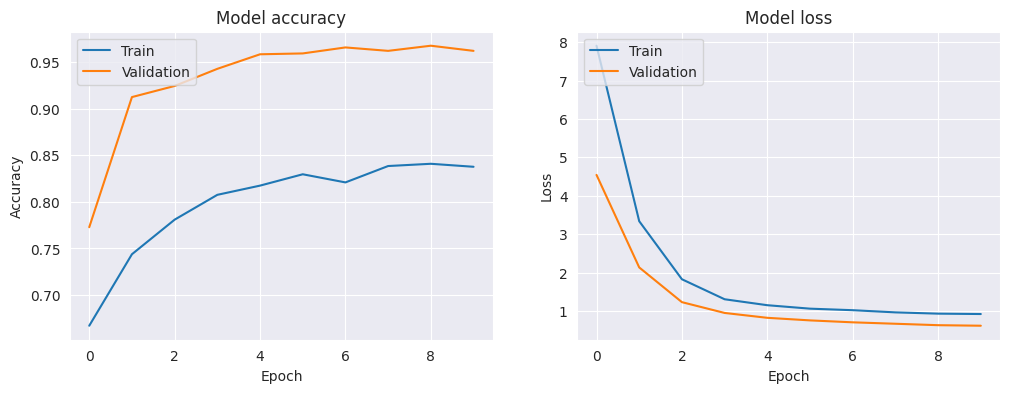

In [ ]:
import matplotlib.pyplot as plt
# Plot learning curves
def plot_learning_curves(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.show()

# Plot learning curves from your training history
plot_learning_curves(history1)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions for the test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Generate classification report
class_names = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:")
print(report)

Test Loss: 0.6445
Test Accuracy: 0.9476
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step

Classification Report:
              precision    recall  f1-score   support

    basophil       0.97      0.93      0.95       126
  eosinophil       0.92      0.98      0.95       300
erythroblast       0.97      0.94      0.96       162
  lymphocyte       0.89      0.95      0.92       122
    monocyte       0.95      0.82      0.88       147
    platelet       0.99      0.99      0.99       230

    accuracy                           0.95      1087
   macro avg       0.95      0.94      0.94      1087
weighted avg       0.95      0.95      0.95      1087



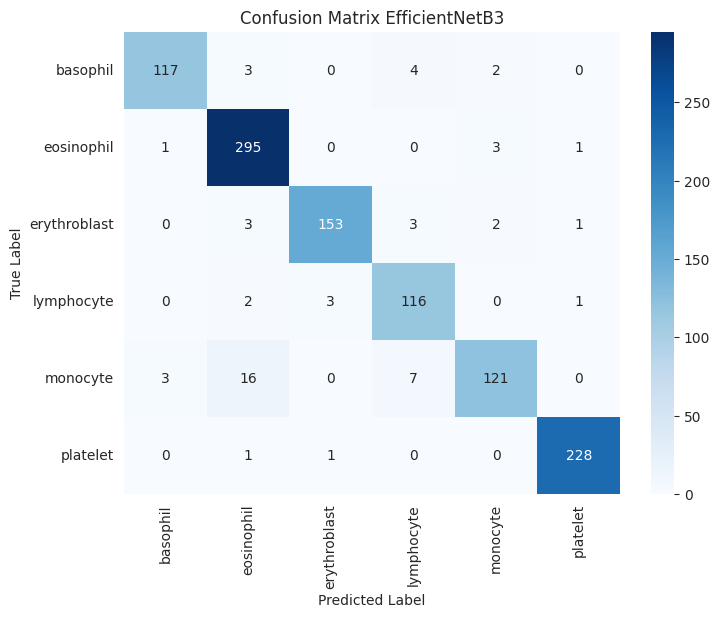

In [ ]:

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix EfficientNetB3')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**ResNet50**

In [ ]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained ResNet50 model without the top layer
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,121,990 (92.02 MB)

 Trainable params: 530,182 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
history2 = model.fit(train_gen, epochs=10, verbose=1, validation_data=valid_gen, shuffle=False)
# Save the entire model to a HDF5 file
model.save('bc_ResNet50.h5')

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.7252 - loss: 10.3647 - val_accuracy: 0.8951 - val_loss: 4.0331
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.8236 - loss: 3.4666 - val_accuracy: 0.9595 - val_loss: 1.8596
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.8437 - loss: 1.7846 - val_accuracy: 0.9660 - val_loss: 1.0887
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - accuracy: 0.8581 - loss: 1.2168 - val_accuracy: 0.9724 - val_loss: 0.8560
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.8726 - loss: 1.0347 - val_accuracy: 0.9687 - val_loss: 0.7559
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.8846 - loss: 0.9287 - val_accuracy: 0.9678 - val_loss: 0.6938
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - accuracy: 0.8855 - loss: 0.8772 - val_accuracy: 0.9761 - val_loss: 0.6353
Epoch 8/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.8974 - loss: 0.8186 -

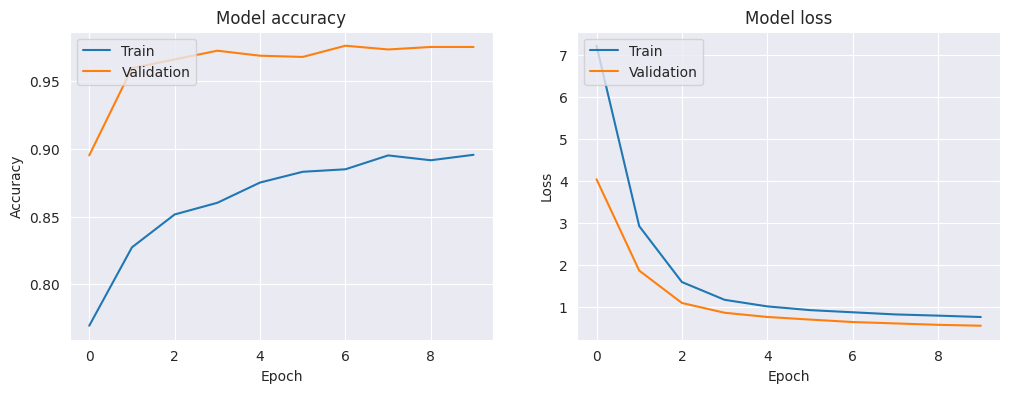

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot learning curves
def plot_learning_curves(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.show()


# Plot learning curves from your training history
plot_learning_curves(history2)


In [ ]:
from sklearn.metrics import classification_report
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions for the test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Generate classification report
class_names = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report ResNet50:")
print(report)

Test Loss: 0.5589
Test Accuracy: 0.9696
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step

Classification Report ResNet50:
              precision    recall  f1-score   support

    basophil       0.96      0.96      0.96       126
  eosinophil       0.97      1.00      0.99       300
erythroblast       0.97      0.96      0.96       162
  lymphocyte       0.92      0.94      0.93       122
    monocyte       0.97      0.93      0.95       147
    platelet       1.00      0.99      0.99       230

    accuracy                           0.97      1087
   macro avg       0.97      0.96      0.96      1087
weighted avg       0.97      0.97      0.97      1087



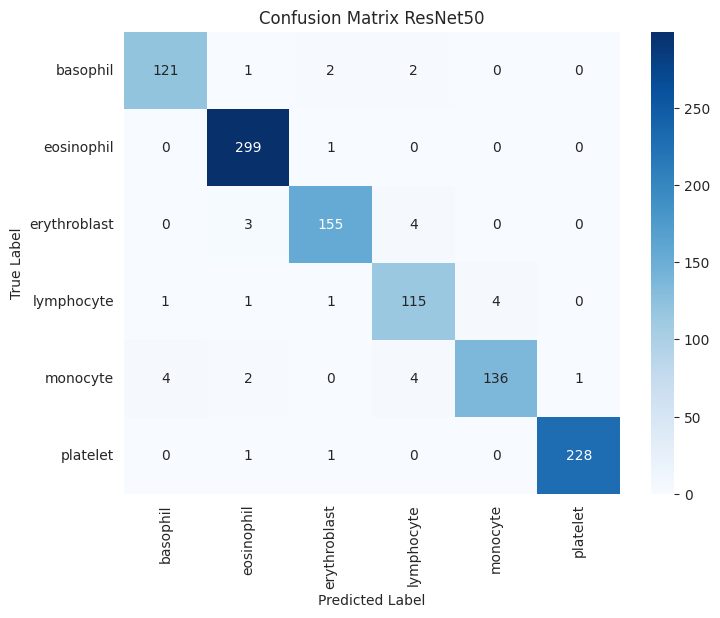

In [ ]:

from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**InceptionV3 model**

In [ ]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained InceptionV3 model without the top layer
base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,337,062 (85.21 MB)

 Trainable params: 530,182 (2.02 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [ ]:
history3 = model.fit(train_gen, epochs=10, verbose=1, validation_data=valid_gen, shuffle=False)
# Save the entire model to a HDF5 file
model.save('bc_InceptionV3.h5')

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 62s 84ms/step - accuracy: 0.6070 - loss: 10.7559 - val_accuracy: 0.7010 - val_loss: 5.0312
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.6318 - loss: 4.3542 - val_accuracy: 0.7571 - val_loss: 2.5911
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.6587 - loss: 2.3855 - val_accuracy: 0.7875 - val_loss: 1.5806
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.6652 - loss: 1.6427 - val_accuracy: 0.8031 - val_loss: 1.2612
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.6788 - loss: 1.4028 - val_accuracy: 0.8096 - val_loss: 1.1264
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.6851 - loss: 1.3172 - val_accuracy: 0.8280 - val_loss: 1.0434
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.6996 - loss: 1.2691 - val_accuracy: 0.8353 - val_loss: 1.0448
Epoch 8/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.6933 - loss: 1.2318 -

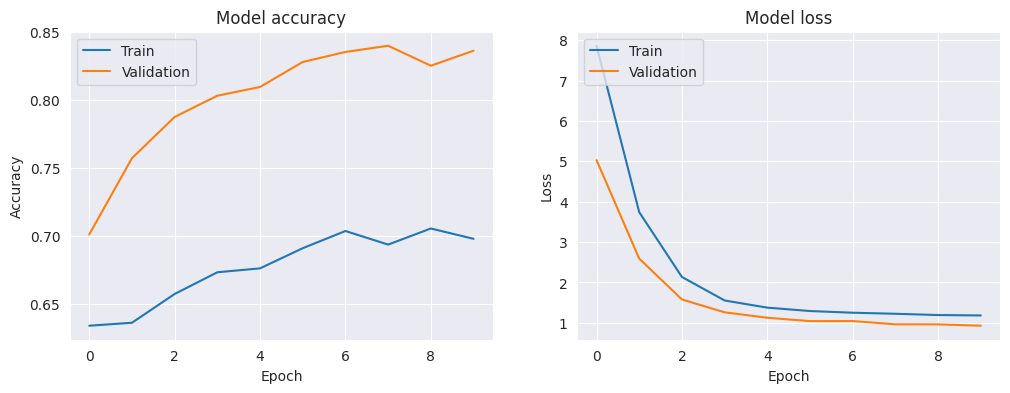

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot learning curves
def plot_learning_curves(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.show()

# Plot learning curves from your training history
plot_learning_curves(history3)

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_gen, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions for the test set
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Generate classification report
class_names = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report of  InceptionV3:")
print(report)


Test Loss: 0.9531
Test Accuracy: 0.8197
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step

Classification Report of  InceptionV3:
              precision    recall  f1-score   support

    basophil       0.82      0.79      0.80       126
  eosinophil       0.76      0.92      0.83       300
erythroblast       0.89      0.69      0.77       162
  lymphocyte       0.75      0.89      0.81       122
    monocyte       0.76      0.46      0.57       147
    platelet       0.95      0.99      0.97       230

    accuracy                           0.82      1087
   macro avg       0.82      0.79      0.79      1087
weighted avg       0.82      0.82      0.81      1087



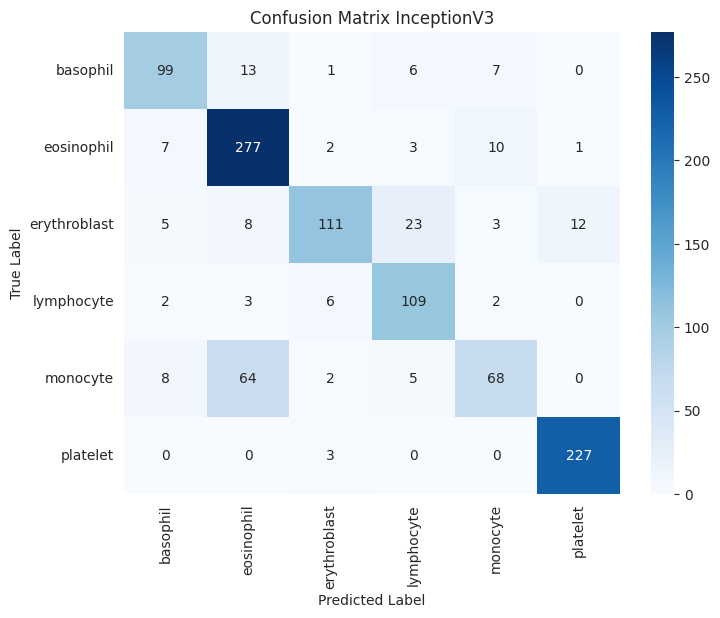

In [ ]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix InceptionV3')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Applying TCAV**

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch import nn
from torchvision import models, transforms
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Identity()  # Removes final layer
model = model.to(device)
model.eval()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

layer_name = "avgpool"
model.avgpool.register_forward_hook(get_activation(layer_name))


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_images_from_folder(folder, max_images=50):
    images = []
    for fname in os.listdir(folder)[:max_images]:
        try:
            img = Image.open(os.path.join(folder, fname)).convert('RGB')
            images.append(transform(img).unsqueeze(0))
        except:
            pass
    return images


In [ ]:
def get_activations_from_images(image_tensors, model):
    outputs = []
    for img in image_tensors:
        _ = model(img.to(device))
        outputs.append(activations[layer_name].cpu().numpy().squeeze())
    return outputs


In [ ]:
def compute_tcav_score(class_images, cav_vector):
    directional_derivatives = []
    for img in class_images:
        _ = model(img.to(device))
        act = activations[layer_name].cpu().numpy().squeeze()
        grad = np.dot(cav_vector, act.flatten())
        directional_derivatives.append(grad)
    score = np.mean(np.array(directional_derivatives) > 0)
    return score


In [ ]:
concepts_path = {
    "lymphocyte": "/content/blood_dataset/bloodcells_dataset/lymphocyte",
    "monocyte": "/content/blood_dataset/bloodcells_dataset/monocyte"
}

random_path = "/content/blood_dataset/bloodcells_dataset/platelet"

class_folders = {
    "basophil": "/content/blood_dataset/bloodcells_dataset/basophil",
    "eosinophil": "/content/blood_dataset/bloodcells_dataset/eosinophil",
    "erythroblast": "/content/blood_dataset/bloodcells_dataset/erythroblast",
    "ig": "/content/blood_dataset/bloodcells_dataset/ig",
    "lymphocyte": "/content/blood_dataset/bloodcells_dataset/lymphocyte",
    "monocyte": "/content/blood_dataset/bloodcells_dataset/monocyte",
    "neutrophil": "/content/blood_dataset/bloodcells_dataset/neutrophil",
    "platelet": "/content/blood_dataset/bloodcells_dataset/platelet"
}


In [ ]:
def compute_tcav_scores_all_classes(concept_name, concept_folder, random_folder):
    concept_imgs = load_images_from_folder(concept_folder)
    random_imgs = load_images_from_folder(random_folder)

    concept_act = get_activations_from_images(concept_imgs, model)
    random_act = get_activations_from_images(random_imgs, model)

    X = np.concatenate([concept_act, random_act])
    y = np.array([1]*len(concept_act) + [0]*len(random_act))
    clf = SGDClassifier(max_iter=1000).fit(X.reshape(len(X), -1), y)
    cav_vector = clf.coef_

    scores = {}
    for class_name, class_folder in class_folders.items():
        class_imgs = load_images_from_folder(class_folder, max_images=20)
        score = compute_tcav_score(class_imgs, cav_vector)
        scores[class_name] = score
    return scores


In [ ]:
lymphocyte_scores = compute_tcav_scores_all_classes(
    concept_name="lymphocyte",
    concept_folder=concepts_path["lymphocyte"],
    random_folder=random_path
)

monocyte_scores = compute_tcav_scores_all_classes(
    concept_name="monocyte",
    concept_folder=concepts_path["monocyte"],
    random_folder=random_path
)


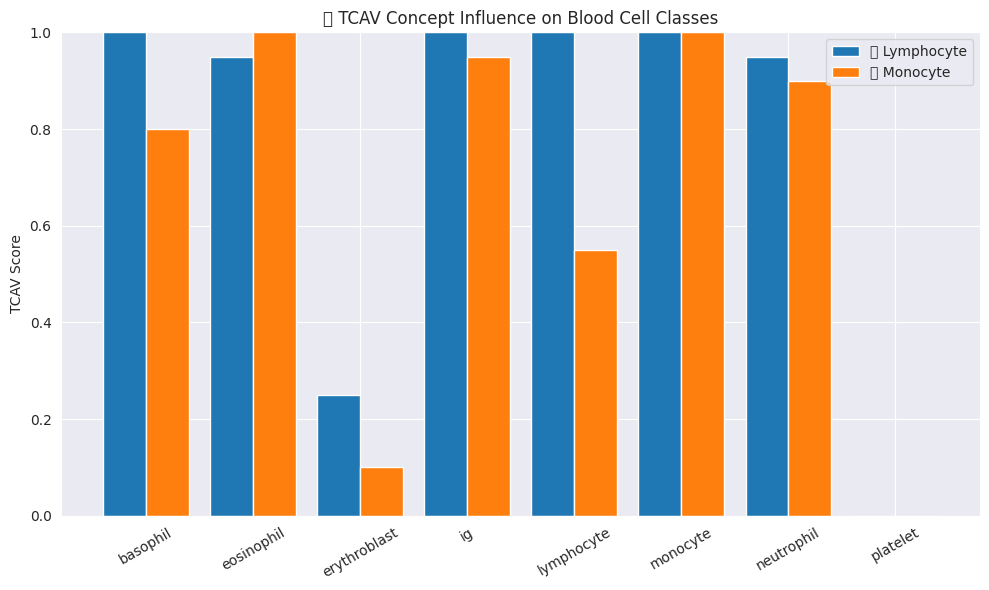

In [ ]:
labels = list(class_folders.keys())
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, [lymphocyte_scores[l] for l in labels], width=0.4, label="🧪 Lymphocyte")
plt.bar(x + 0.2, [monocyte_scores[l] for l in labels], width=0.4, label="🧬 Monocyte")
plt.xticks(x, labels, rotation=30)
plt.ylim(0, 1)
plt.title("🧠 TCAV Concept Influence on Blood Cell Classes")
plt.ylabel("TCAV Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import random

def random_concept_paths(all_folders, k):
    return [random.sample(all_folders, k) for _ in range(K)]

def compute_significance(concept_name, concept_folder, random_base_folders, k_random=5, alpha=0.05): # Added concept_name as argument
    # 1) compute true score
    true_scores = compute_tcav_scores_all_classes(
        concept_name, concept_folder, random_path # concept_name is now available
    )
    p_values = {}
    for cls, true_score in true_scores.items():
        random_scores = []
        for _ in range(k_random):
            # pick k_random random “concept” folders
            # r_set = random.choice(random_base_folders)  # This line was causing the error
            r_set = random.choice(random_base_folders)[0]  # Select a single path from the list
            rs = compute_tcav_scores_all_classes(concept_name, r_set, random_path)[cls]
            random_scores.append(rs)
        p = sum(1 for rs in random_scores if rs >= true_score) / k_random
        p_values[cls] = p
    return true_scores, p_values

# Example usage:
all_class_paths = list(class_folders.values())
true_vs_p = compute_significance(
    "lymphocyte", # Passing the concept name explicitly
    concepts_path['lymphocyte'],
    [random.sample(all_class_paths, 2) for _ in range(10)],
    k_random=10
)
print("TCAV scores:", true_vs_p[0])
print("p‑values:", true_vs_p[1])

TCAV scores: {'basophil': np.float64(1.0), 'eosinophil': np.float64(1.0), 'erythroblast': np.float64(0.65), 'ig': np.float64(1.0), 'lymphocyte': np.float64(1.0), 'monocyte': np.float64(1.0), 'neutrophil': np.float64(1.0), 'platelet': np.float64(0.2)}
p‑values: {'basophil': 0.1, 'eosinophil': 0.2, 'erythroblast': 0.2, 'ig': 0.4, 'lymphocyte': 0.2, 'monocyte': 0.5, 'neutrophil': 0.0, 'platelet': 0.3}


In [ ]:
import pandas as pd

# Assign the output of compute_significance to variables
true_scores, p_values = true_vs_p  # Unpack the tuple

# Now you can use true_scores and p_values to create the DataFrame
df = pd.DataFrame({
    "TCAV Score": true_scores,
    "p-value":    p_values
})
df["Significant"] = df["p-value"] < 0.05

print(df.sort_values("p-value"))

              TCAV Score  p-value  Significant
neutrophil          1.00      0.0         True
basophil            1.00      0.1        False
erythroblast        0.65      0.2        False
eosinophil          1.00      0.2        False
lymphocyte          1.00      0.2        False
platelet            0.20      0.3        False
ig                  1.00      0.4        False
monocyte            1.00      0.5        False
